<a href="https://colab.research.google.com/github/Shiro03kuuhaku/Comparison-of-LSTM-CNN-GRU-and-IndoBERTweet-Methods/blob/main/UAS_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install tf-keras==2.11.0 tensorflow==2.11.0 --quiet
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Saving PRDECT_ID.csv to PRDECT_ID.csv
Epoch 1/3
122/122 [==============================] - 14s 90ms/step - loss: 1.5610 - accuracy: 0.3259 - val_loss: 1.5647 - val_accuracy: 0.2986
Epoch 2/3
122/122 [==============================] - 10s 83ms/step - loss: 1.5592 - accuracy: 0.3297 - val_loss: 1.5604 - val_accuracy: 0.2986
Epoch 3/3
122/122 [==============================] - 11s 86ms/step - loss: 1.5586 - accuracy: 0.3308 - val_loss: 1.5607 - val_accuracy: 0.2986


/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/3
122/122 [==============================] - 13s 85ms/step - loss: 1.5596 - accuracy: 0.3292 - val_loss: 1.5581 - val_accuracy: 0.2986
Epoch 2/3
122/122 [==============================] - 19s 157ms/step - loss: 1.5605 - accuracy: 0.3308 - val_loss: 1.5622 - val_accuracy: 0.2986
Epoch 3/3
122/122 [==============================] - 10s 81ms/step - loss: 1.5565 - accuracy: 0.3305 - val_loss: 1.5617 - val_accuracy: 0.2986
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


122/122 [==============================] - 9s 63ms/step - loss: 1.4388 - accuracy: 0.3876 - val_loss: 1.1840 - val_accuracy: 0.5208
Epoch 2/3
122/122 [==============================] - 6s 52ms/step - loss: 1.0697 - accuracy: 0.5391 - val_loss: 0.9790 - val_accuracy: 0.5856
Epoch 3/3
122/122 [==============================] - 7s 61ms/step - loss: 0.7972 - accuracy: 0.6685 - val_loss: 0.9026 - val_accuracy: 0.6366


/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/468 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


tf_model.h5:   0%|          | 0.00/545M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at cahya/bert-base-indonesian-522M and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
338/338 [==============================] - 8337s 25s/step - loss: 1.5594 - accuracy: 0.3354
Epoch 2/3
338/338 [==============================] - 8115s 24s/step - loss: 1.2567 - accuracy: 0.4417
Epoch 3/3
34/34 [==============================] - 2s 24ms/step

--- LSTM ---
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00       145
        Fear       0.00      0.00      0.00       159
       Happy       0.33      1.00      0.50       356
        Love       0.00      0.00      0.00       167
     Sadness       0.00      0.00      0.00       253

    accuracy                           0.33      1080
   macro avg       0.07      0.20      0.10      1080
weighted avg       0.11      0.33      0.16      1080



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


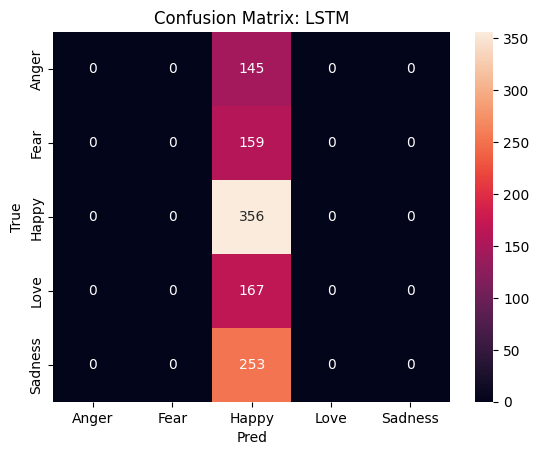

34/34 [==============================] - 1s 15ms/step

--- GRU ---
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00       145
        Fear       0.00      0.00      0.00       159
       Happy       0.33      1.00      0.50       356
        Love       0.00      0.00      0.00       167
     Sadness       0.00      0.00      0.00       253

    accuracy                           0.33      1080
   macro avg       0.07      0.20      0.10      1080
weighted avg       0.11      0.33      0.16      1080



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


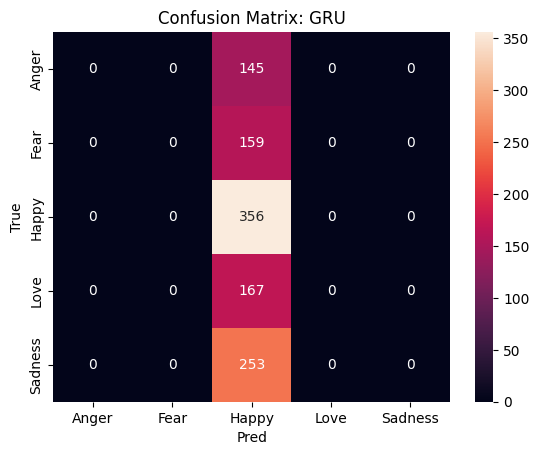

34/34 [==============================] - 1s 13ms/step

--- CNN ---
              precision    recall  f1-score   support

       Anger       0.46      0.15      0.23       145
        Fear       0.38      0.52      0.44       159
       Happy       0.71      0.81      0.76       356
        Love       0.59      0.51      0.55       167
     Sadness       0.59      0.63      0.61       253

    accuracy                           0.59      1080
   macro avg       0.55      0.52      0.52      1080
weighted avg       0.58      0.59      0.57      1080



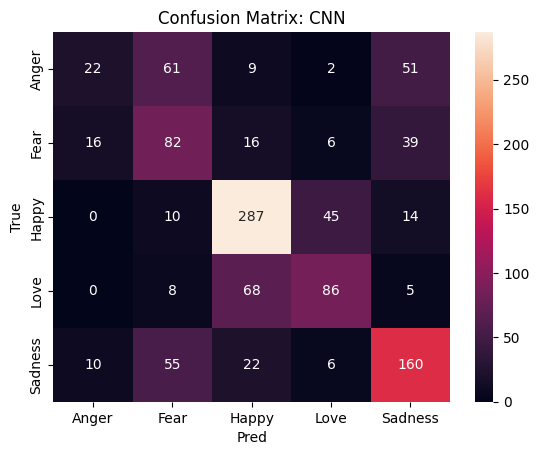

169/169 [==============================] - 2483s 15s/step

--- BERT ---
              precision    recall  f1-score   support

       Anger       0.70      0.02      0.04       699
        Fear       0.75      0.03      0.06       920
       Happy       0.76      0.91      0.83      1770
        Love       0.80      0.56      0.66       809
     Sadness       0.42      0.92      0.57      1202

    accuracy                           0.59      5400
   macro avg       0.69      0.49      0.43      5400
weighted avg       0.68      0.59      0.51      5400



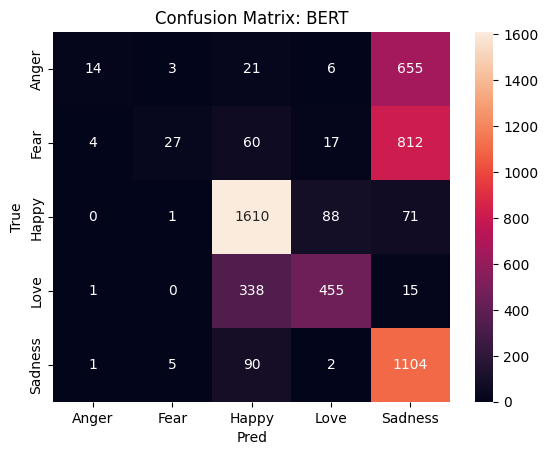

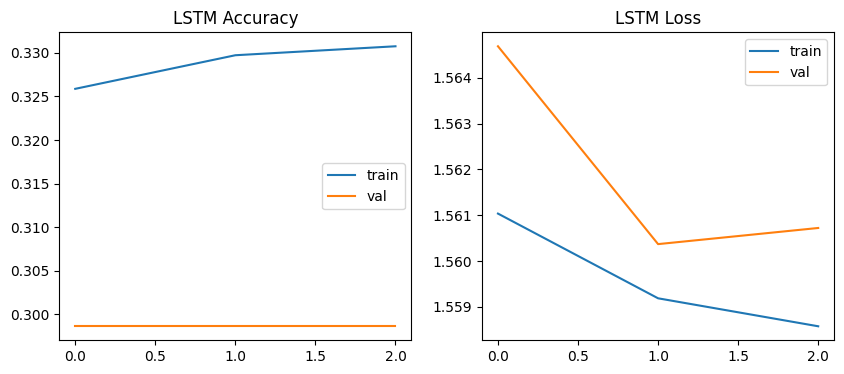

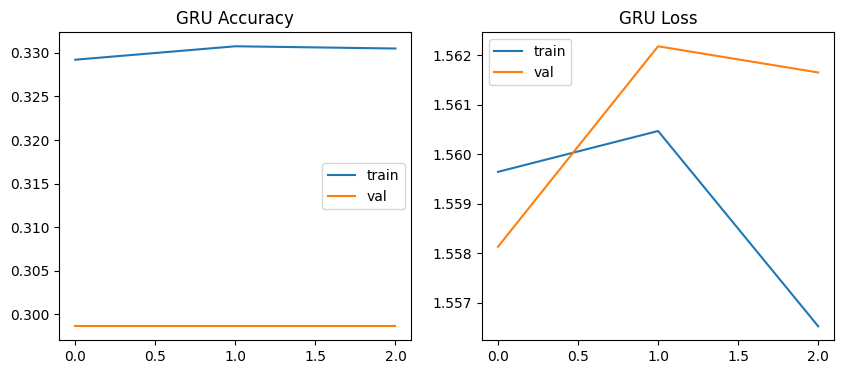

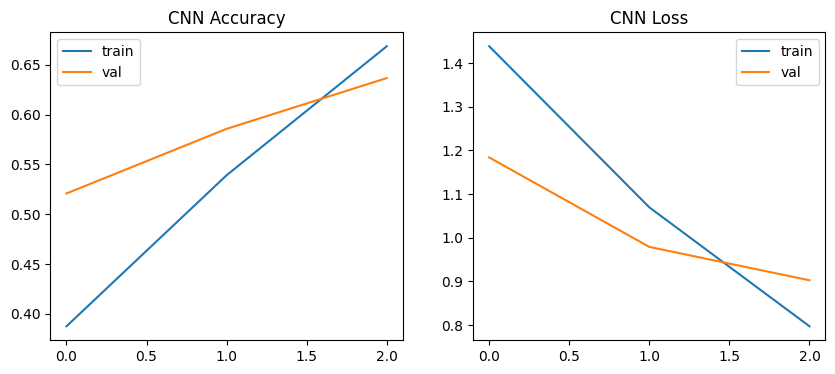

In [ ]:
# === 1. Import & Preprocessing ===
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import tensorflow as tf
import re, string
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from nltk.corpus import stopwords
import nltk; nltk.download('stopwords')
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from tensorflow.keras.optimizers import Adam

from google.colab import files
uploaded = files.upload()

# === 2. Load Dataset ===
df = pd.read_csv("PRDECT_ID.csv")
df.columns = df.columns.str.strip()
df.rename(columns={'Customer Review': 'review', 'Emotion': 'emotion'}, inplace=True)
df.dropna(subset=['review', 'emotion'], inplace=True)

# === 3. Cleaning & Encoding ===
stop_words = set(stopwords.words('indonesian'))
def clean_text(t):
    t = "".join(c for c in t.lower() if c.isalpha() or c.isspace())
    return " ".join(w for w in t.split() if w not in stop_words)

df['clean_review'] = df['review'].apply(clean_text)
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['emotion'])
num_classes = len(label_encoder.classes_)

# === 4. Tokenizing LSTM/GRU/CNN ===
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(df['clean_review'])
X_seq = tokenizer.texts_to_sequences(df['clean_review'])
X_pad = pad_sequences(X_seq, maxlen=100, padding='post')
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)

# === 5. Build & Train LSTM ===
model_lstm = Sequential([
    Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128, input_length=100),
    LSTM(64),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
hist_lstm = model_lstm.fit(X_train, y_train, validation_split=0.1, epochs=3, batch_size=32)
model_lstm.save("model_lstm.h5")

# === 6. Build & Train GRU ===
model_gru = Sequential([
    Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128, input_length=100),
    GRU(64),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
model_gru.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
hist_gru = model_gru.fit(X_train, y_train, validation_split=0.1, epochs=3, batch_size=32)
model_gru.save("model_gru.h5")

# === 7. Build & Train CNN ===
model_cnn = Sequential([
    Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128, input_length=100),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
model_cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
hist_cnn = model_cnn.fit(X_train, y_train, validation_split=0.1, epochs=3, batch_size=32)
model_cnn.save("model_cnn.h5")

# === 8. IndoBERTweet ===
bert_tokenizer = AutoTokenizer.from_pretrained("cahya/bert-base-indonesian-522M")
bert_enc_train = bert_tokenizer(list(df['clean_review']), padding=True, truncation=True, max_length=128, return_tensors='tf')
dataset = tf.data.Dataset.from_tensor_slices(({
    'input_ids': bert_enc_train['input_ids'],
    'attention_mask': bert_enc_train['attention_mask']
}, df['label'].values)).batch(16)

bert_model = TFAutoModelForSequenceClassification.from_pretrained("cahya/bert-base-indonesian-522M", num_labels=num_classes)
bert_model.compile(optimizer=Adam(learning_rate=2e-5),
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])
bert_model.fit(dataset, epochs=3)
bert_model.save_pretrained("bert_model")

# === 9. Evaluation Function ===
def evaluate_model(model, X, y_true, name, is_bert=False):
    if is_bert:
        preds = model.predict(X)['logits']
        y_pred = np.argmax(preds, axis=1)
    else:
        preds = model.predict(X)
        y_pred = np.argmax(preds, axis=1)
    print(f"\n--- {name} ---")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix: {name}'); plt.xlabel('Pred'); plt.ylabel('True'); plt.show()

# === 10. Evaluation ===
evaluate_model(model_lstm, X_test, y_test, "LSTM")
evaluate_model(model_gru, X_test, y_test, "GRU")
evaluate_model(model_cnn, X_test, y_test, "CNN")

# === 11. Evaluate BERT ===
bert_enc_test = bert_tokenizer(list(df['clean_review']), padding=True, truncation=True, max_length=128, return_tensors='tf')
bert_test_dataset = {
    'input_ids': bert_enc_test['input_ids'],
    'attention_mask': bert_enc_test['attention_mask']
}
evaluate_model(bert_model, bert_test_dataset, df['label'].values, "BERT", is_bert=True)

# === 12. Plot Accuracy & Loss ===
def plot_history(history, title):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title(f'{title} Accuracy'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title(f'{title} Loss'); plt.legend()
    plt.show()

plot_history(hist_lstm, "LSTM")
plot_history(hist_gru, "GRU")
plot_history(hist_cnn, "CNN")


In [ ]:
# ✅ Install library
!pip install -q transformers datasets nltk scikit-learn

# ✅ Import dan Preprocessing
import pandas as pd, numpy as np, re, string
import nltk, matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('indonesian'))

# ✅ Load dataset
df = pd.read_csv("PRDECT_ID.csv")
df.columns = df.columns.str.strip()
df.rename(columns={'Customer Review': 'review', 'Emotion': 'emotion'}, inplace=True)
df.dropna(subset=['review', 'emotion'], inplace=True)

# ✅ Bersihkan & encode label
def clean_text(t):
    t = "".join(c for c in t.lower() if c.isalpha() or c.isspace())
    return " ".join(w for w in t.split() if w not in stop_words)

df['clean_review'] = df['review'].apply(clean_text)
df = df.sample(frac=0.3, random_state=42)  # hanya 30% data

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['emotion'])

# ✅ Split data
X_train, X_test, y_train, y_test = train_test_split(df['clean_review'], df['label'], test_size=0.2, random_state=42)

# ✅ Tokenizer IndoBERT ringan
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=64)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=64)

# ✅ TF Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train)).batch(8)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_test)).batch(8)

# ✅ Load model
num_classes = len(label_encoder.classes_)
bert_model = TFAutoModelForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-base-p1", num_labels=num_classes
)

# ✅ Compile
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=2e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
bert_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# ✅ Train
history = bert_model.fit(train_dataset, validation_data=test_dataset, epochs=2)

# ✅ Save model
bert_model.save_pretrained("bert_model_indoemotion")

# ✅ Evaluate
y_pred_probs = bert_model.predict(test_dataset).logits
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# ✅ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(np.arange(num_classes), label_encoder.classes_, rotation=45)
plt.yticks(np.arange(num_classes), label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ✅ Plot Accuracy & Loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Loss")
plt.legend()
plt.show()